<a href="https://colab.research.google.com/github/erosas-utec/datascience/blob/main/Forecasting_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# Forecasting de Ventas Walmart – Versión *Store-Level*
# ============================================================
# Este cuaderno está ajustado al CSV que contiene ventas
# semanales **por tienda** (sin columna Dept) y usa ‘Holiday_Flag’
# en lugar de ‘IsHoliday’.

# Flujo general:
# 1.  Instalación / imports
# 2.  Carga y exploración
# 3.  Limpieza + Feature Engineering
# 4.  Split temporal 70-15-15
# 5.  Random Forest con GridSearch
# 6.  LSTM (Keras + GPU)
# 7.  Modelo híbrido LSTM → RF
# 8.  Métricas finales y feature importance
# ============================================================


import pandas as pd
import numpy as np
import holidays
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tqdm.auto import tqdm

# 2 ───────────────────────────────────────────────────────────
# Carga y exploración
DATA_PATH = Path('/content/Walmart_Dataset.csv')  # <- ajusta si tu ruta es distinta
df = pd.read_csv(DATA_PATH)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

print("Columnas:", list(df.columns))
print(df.head())

# 3 ───────────────────────────────────────────────────────────
# Limpieza y Feature Engineering

# 3.1 Variables temporales
df['Year']    = df['Date'].dt.year
df['Month']   = df['Date'].dt.month
df['Week']    = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter'] = df['Date'].dt.quarter

# 3.2 Festivos de EE. UU.
us_holidays = holidays.US()
df['Is_US_Holiday'] = df['Date'].isin(us_holidays).astype(int)

# 3.3 Lags y medias móviles por tienda
for lag in [1, 2, 4]:
    df[f'Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)

df['Rolling_4']  = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(4).mean()
df['Rolling_12'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(12).mean()

# 3.4 Drop de filas con NaN generadas por los lags/rolling
df = df.dropna().reset_index(drop=True)

# 4 ───────────────────────────────────────────────────────────
# Split temporal train / valid / test (70-15-15)

total_weeks = df['Date'].nunique()
train_weeks = int(total_weeks * 0.70)
valid_weeks = int(total_weeks * 0.15)

dates_sorted = df['Date'].sort_values().unique()
train_cutoff = dates_sorted[train_weeks - 1]
valid_cutoff = dates_sorted[train_weeks + valid_weeks - 1]

train_df = df[df['Date'] <= train_cutoff].copy()
valid_df = df[(df['Date'] > train_cutoff) & (df['Date'] <= valid_cutoff)].copy()
test_df  = df[df['Date'] > valid_cutoff].copy()

FEATURES = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'Holiday_Flag', 'Is_US_Holiday',
            'Year', 'Month', 'Week', 'Quarter',
            'Lag_1', 'Lag_2', 'Lag_4', 'Rolling_4', 'Rolling_12']
TARGET = 'Weekly_Sales'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_valid, y_valid = valid_df[FEATURES], valid_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

# 5 ───────────────────────────────────────────────────────────
# Random Forest Regressor

rf_params = {
    'n_estimators':      [400, 500, 600],
    'max_depth':         [None, 10, 15],
    'min_samples_leaf':  [1, 2, 4]
}
tscv = TimeSeriesSplit(n_splits=3)
rf_base = RandomForestRegressor(n_jobs=-1, random_state=42)

grid_rf = GridSearchCV(
    rf_base, rf_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print(f"🎯 Mejor RF params: {grid_rf.best_params_}")

# 6 ───────────────────────────────────────────────────────────
# LSTM – preparación de secuencias

LOOK_BACK = 4
SCALER = MinMaxScaler()

def create_sequences(df_part, features, target, look_back=LOOK_BACK):
    X_seq, y_seq = [], []
    for _, grp in df_part.groupby('Store'):
        feat = grp[features].values.astype(np.float32)
        targ = grp[target].values.astype(np.float32)
        feat_scaled = SCALER.fit_transform(feat)
        for i in range(look_back, len(feat_scaled)):
            X_seq.append(feat_scaled[i - look_back:i])
            y_seq.append(targ[i])
    return np.array(X_seq), np.array(y_seq)

X_train_lstm, y_train_lstm = create_sequences(train_df, FEATURES, TARGET)
X_valid_lstm, y_valid_lstm = create_sequences(valid_df, FEATURES, TARGET)
X_test_lstm,  y_test_lstm  = create_sequences(test_df,  FEATURES, TARGET)

# Arquitectura LSTM
def make_lstm_model():
    model = models.Sequential([
        layers.Input(shape=(LOOK_BACK, len(FEATURES))),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

model = make_lstm_model()
early = callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=50, batch_size=256,
    callbacks=[early], verbose=2
)

# 7 ───────────────────────────────────────────────────────────
# Crear feature LSTM_pred y entrenar modelo híbrido

def add_lstm_pred(df_source):
    """
    Inserta la predicción LSTM en la misma granularidad tienda-semana.
    Las primeras LOOK_BACK semanas quedan como NaN y se descartan luego.
    """
    preds = []
    idx_map = []
    for store, grp in df_source.groupby('Store'):
        feat = grp[FEATURES].values.astype(np.float32)
        feat_scaled = SCALER.fit_transform(feat)
        # Crear ventanas
        store_X = []
        for i in range(LOOK_BACK, len(feat_scaled)):
            store_X.append(feat_scaled[i-LOOK_BACK:i])
        # Predicciones
        store_pred = model.predict(np.array(store_X), verbose=0).flatten()
        # Padding delante para alinear
        store_pred = [np.nan]*LOOK_BACK + store_pred.tolist()
        preds.extend(store_pred)
        idx_map.extend(grp.index.tolist())
    df_source['lstm_pred'] = pd.Series(preds, index=idx_map)
    return df_source.dropna(subset=['lstm_pred'])

train_h = add_lstm_pred(train_df.copy())
valid_h = add_lstm_pred(valid_df.copy())
test_h  = add_lstm_pred(test_df.copy())

FEATURES_H = FEATURES + ['lstm_pred']

X_train_h, y_train_h = train_h[FEATURES_H], train_h[TARGET]
X_valid_h, y_valid_h = valid_h[FEATURES_H], valid_h[TARGET]
X_test_h,  y_test_h  = test_h[FEATURES_H],  test_h[TARGET]

rf_hybrid = RandomForestRegressor(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    min_samples_leaf=grid_rf.best_params_['min_samples_leaf'],
    n_jobs=-1,
    random_state=42
).fit(X_train_h, y_train_h)


Columnas: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   6.0s
[CV] END max_depth=None, m

In [2]:

# 8 ───────────────────────────────────────────────────────────
# Métricas finales

def evaluate(name, y_true, y_pred):
    """
    Devuelve RMSE, MAE y MAPE (en %) para un par de vectores.
    Compatible con scikit-learn viejas.
    """
    mse  = mean_squared_error(y_true, y_pred)   # siempre existe
    rmse = np.sqrt(mse)                         # raíz para obtener RMSE
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

results = []
results.append(evaluate('RF', y_test, best_rf.predict(X_test)))
results.append(evaluate('LSTM', y_test_lstm, model.predict(X_test_lstm).flatten()))
results.append(evaluate('Híbrido', y_test_h, rf_hybrid.predict(X_test_h)))

print("\n====== Resultados en TEST ======")
for r in results:
    print(f"{r['Model']}: RMSE={r['RMSE']:.0f} | MAE={r['MAE']:.0f} | MAPE={r['MAPE']:.2f}%")

# 9 ───────────────────────────────────────────────────────────
# Importancia de variables (RF baseline)
importances = pd.Series(best_rf.feature_importances_, index=FEATURES)
print("\nTop 10 features RF:")
print(importances.sort_values(ascending=False).head(10))

# 10 ──────────────────────────────────────────────────────────
# Guardado de modelos (opcional)
# import joblib, pickle
# joblib.dump(best_rf, '/content/rf_store.pkl')
# model.save('/content/lstm_store.h5')
# joblib.dump(rf_hybrid, '/content/rf_hybrid_store.pkl')


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

====== Resultados en TEST ======
RF: RMSE=62832 | MAE=43413 | MAPE=4.26%
LSTM: RMSE=1159376 | MAE=1031550 | MAPE=99.96%
Híbrido: RMSE=64282 | MAE=44488 | MAPE=4.37%

Top 10 features RF:
Rolling_4       0.450606
Lag_1           0.371859
Rolling_12      0.086873
Week            0.039217
Lag_4           0.032695
Lag_2           0.007666
Holiday_Flag    0.002099
Temperature     0.001703
CPI             0.001614
Unemployment    0.001553
dtype: float64


In [3]:
# ============================================================
# CONFIGURACIÓN COMÚN (ejecuta solo una vez)
# ============================================================
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf, numpy as np
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from copy import deepcopy   # para clonar funciones y no pisar variables

# ---------- función LSTM parametrizable ----------------------
def make_lstm(units1=64, units2=32, look_back=4, dropout=0.2, n_feats=len(FEATURES)):
    model = models.Sequential([
        layers.Input(shape=(look_back, n_feats)),
        layers.LSTM(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units2),
        layers.Dense(1)
    ])
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# ---------- función train + early stopping -------------------
def train_lstm(model, X_tr, y_tr, X_val, y_val, epochs=50, batch=256):
    es = callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                 patience=5, restore_best_weights=True)
    model.fit(X_tr, y_tr,
              validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch, verbose=0,
              callbacks=[es])
    return model


In [5]:
#🔹 E1 – Baseline (RF y LSTM simples)
# RANDOM FOREST BASELINE (parámetros por defecto)
from sklearn.ensemble import RandomForestRegressor
rf_base = RandomForestRegressor(
    n_estimators=100,      # default
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

# LSTM BASELINE (arquitectura liviana)
model_base = tf.keras.Sequential([
    layers.Input(shape=(LOOK_BACK, len(FEATURES))),
    layers.LSTM(32),
    layers.Dense(1)
])
model_base.compile(
    loss='mse',
    optimizer='adam',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_base.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=30, batch_size=128,
    verbose=2
)


Epoch 1/30
31/31 - 1s - 45ms/step - loss: 1443886530560.0000 - root_mean_squared_error: 1201618.2500 - val_loss: 1382274433024.0000 - val_root_mean_squared_error: 1175701.6250
Epoch 2/30
31/31 - 0s - 7ms/step - loss: 1443879976960.0000 - root_mean_squared_error: 1201615.5000 - val_loss: 1382265389056.0000 - val_root_mean_squared_error: 1175697.7500
Epoch 3/30
31/31 - 0s - 8ms/step - loss: 1443870932992.0000 - root_mean_squared_error: 1201611.7500 - val_loss: 1382257917952.0000 - val_root_mean_squared_error: 1175694.6250
Epoch 4/30
31/31 - 0s - 11ms/step - loss: 1443865165824.0000 - root_mean_squared_error: 1201609.3750 - val_loss: 1382254116864.0000 - val_root_mean_squared_error: 1175693.0000
Epoch 5/30
31/31 - 0s - 6ms/step - loss: 1443861626880.0000 - root_mean_squared_error: 1201607.8750 - val_loss: 1382250971136.0000 - val_root_mean_squared_error: 1175691.6250
Epoch 6/30
31/31 - 0s - 10ms/step - loss: 1443858743296.0000 - root_mean_squared_error: 1201606.7500 - val_loss: 1382248087

In [6]:
#🔹 E2 – Hyper-tuning (RF_grid + LSTM_tuned)
# RANDOM FOREST con GridSearch (ya lo tenías como best_rf)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

rf_params = {
    'n_estimators': [400, 500, 600],
    'max_depth':   [None, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}
tscv = TimeSeriesSplit(n_splits=3)
rf_tuned = GridSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    rf_params, cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
).fit(X_train, y_train).best_estimator_

# LSTM TUNEADA (más unidades + dropout)
def make_lstm_tuned():
    m = tf.keras.Sequential([
        layers.Input(shape=(LOOK_BACK, len(FEATURES))),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return m

model_tuned = make_lstm_tuned()
early = callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5, restore_best_weights=True)
model_tuned.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=50, batch_size=256,
    callbacks=[early], verbose=2)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   6.1s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=  11.3s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=   9.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=  13.1s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=  18.2s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   6.3s
[CV] END max_depth=None, min_samples_

In [7]:
#🔹 E3 – Ablation (sin variables externas)
# 1. Definir FEATURES sin macro-variables ni clima
EXOG = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FEATURES_NOEXOG = [c for c in FEATURES if c not in EXOG]

# 2. Construir matrices
X_train_nx = train_df[FEATURES_NOEXOG]
X_valid_nx = valid_df[FEATURES_NOEXOG]
X_test_nx  = test_df[FEATURES_NOEXOG]

# 3. RANDOM FOREST sin exógenas
rf_noexog = RandomForestRegressor(
    n_estimators=rf_tuned.n_estimators,
    max_depth=rf_tuned.max_depth,
    min_samples_leaf=rf_tuned.min_samples_leaf,
    n_jobs=-1, random_state=42
).fit(X_train_nx, y_train)

# 4. LSTM sin exógenas
X_train_lstm_nx, y_train_lstm = create_sequences(train_df, FEATURES_NOEXOG, TARGET)
X_valid_lstm_nx, y_valid_lstm = create_sequences(valid_df, FEATURES_NOEXOG, TARGET)
X_test_lstm_nx,  y_test_lstm  = create_sequences(test_df,  FEATURES_NOEXOG, TARGET)

lstm_noexog = tf.keras.Sequential([
    layers.Input(shape=(LOOK_BACK, len(FEATURES_NOEXOG))),
    layers.LSTM(64), layers.Dense(1)
])
lstm_noexog.compile(loss='mse', optimizer='adam',
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])
lstm_noexog.fit(
    X_train_lstm_nx, y_train_lstm,
    validation_data=(X_valid_lstm_nx, y_valid_lstm),
    epochs=40, batch_size=128, verbose=2)




Epoch 1/40
31/31 - 1s - 46ms/step - loss: 1443886137344.0000 - root_mean_squared_error: 1201618.1250 - val_loss: 1382273122304.0000 - val_root_mean_squared_error: 1175701.1250
Epoch 2/40
31/31 - 0s - 7ms/step - loss: 1443874340864.0000 - root_mean_squared_error: 1201613.2500 - val_loss: 1382255034368.0000 - val_root_mean_squared_error: 1175693.3750
Epoch 3/40
31/31 - 0s - 9ms/step - loss: 1443859660800.0000 - root_mean_squared_error: 1201607.1250 - val_loss: 1382246514688.0000 - val_root_mean_squared_error: 1175689.7500
Epoch 4/40
31/31 - 0s - 6ms/step - loss: 1443852713984.0000 - root_mean_squared_error: 1201604.2500 - val_loss: 1382240616448.0000 - val_root_mean_squared_error: 1175687.2500
Epoch 5/40
31/31 - 0s - 6ms/step - loss: 1443847077888.0000 - root_mean_squared_error: 1201601.8750 - val_loss: 1382235373568.0000 - val_root_mean_squared_error: 1175685.0000
Epoch 6/40
31/31 - 0s - 11ms/step - loss: 1443842097152.0000 - root_mean_squared_error: 1201599.7500 - val_loss: 13822303928

In [8]:
#🔹 E4 – Modelo híbrido (LSTM_pred → RF)
# 1. Obtener predicciones de la LSTM_tuned en cada set
def add_lstm_pred(df_src, feats):
    preds, idx = [], []
    for store, g in df_src.groupby('Store'):
        X_seq, _ = create_sequences(g, feats, TARGET)
        pred = model_tuned.predict(X_seq, verbose=0).flatten()
        # padding
        pred = [np.nan]*LOOK_BACK + pred.tolist()
        preds.extend(pred)
        idx.extend(g.index)
    df_src = df_src.copy()
    df_src['lstm_pred'] = pd.Series(preds, index=idx)
    return df_src.dropna(subset=['lstm_pred'])

train_h = add_lstm_pred(train_df, FEATURES)
valid_h = add_lstm_pred(valid_df, FEATURES)
test_h  = add_lstm_pred(test_df,  FEATURES)

FEATURES_H = FEATURES + ['lstm_pred']
X_train_h, y_train_h = train_h[FEATURES_H], train_h[TARGET]
X_test_h,  y_test_h  = test_h[FEATURES_H],  test_h[TARGET]

# 2. RF sobre las features + lstm_pred
rf_hybrid = RandomForestRegressor(
    n_estimators=rf_tuned.n_estimators,
    max_depth=rf_tuned.max_depth,
    min_samples_leaf=rf_tuned.min_samples_leaf,
    n_jobs=-1, random_state=42
).fit(X_train_h, y_train_h)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Experimento,Modelo,RMSE,MAE,MAPE
0,E1,RF_base,6.444441e+04,4.589701e+04,4.853498
1,E1,LSTM_base,1.159609e+06,1.031812e+06,99.994528
2,E2,RF_tuned,6.283173e+04,4.341309e+04,4.260605
3,E2,LSTM_tuned,1.159388e+06,1.031564e+06,99.961406
4,E3,RF_noExog,6.221702e+04,4.234517e+04,4.031661
5,E3,LSTM_noExog,1.159561e+06,1.031758e+06,99.987376
6,E4,Hybrid,6.442096e+04,4.455410e+04,4.380192


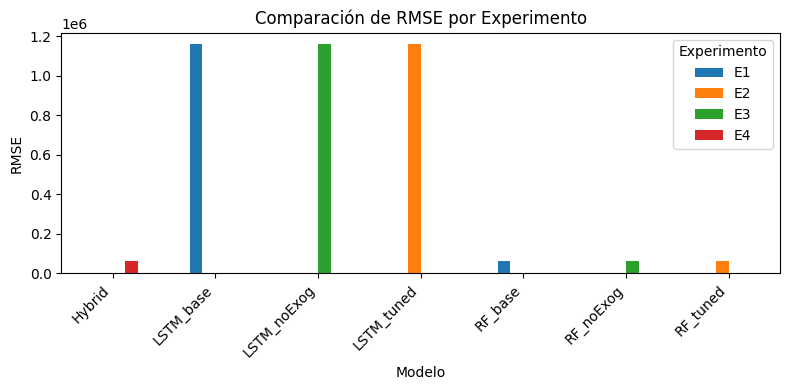

In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ───── 1. función utilitaria ────────────────────────────────
def log_result(lst, exp_id, model_name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    lst.append({
        'Experimento': exp_id,
        'Modelo': model_name,
        'RMSE':  np.sqrt(mse),
        'MAE':   mean_absolute_error(y_true, y_pred),
        'MAPE':  mean_absolute_percentage_error(y_true, y_pred)*100
    })

# ───── 2. registrar resultados ──────────────────────────────
records = []
log_result(records, 'E1', 'RF_base',    y_test,      rf_base.predict(X_test))
log_result(records, 'E1', 'LSTM_base',  y_test_lstm, model_base.predict(X_test_lstm).flatten())

log_result(records, 'E2', 'RF_tuned',   y_test,      rf_tuned.predict(X_test))
log_result(records, 'E2', 'LSTM_tuned', y_test_lstm, model_tuned.predict(X_test_lstm).flatten())

log_result(records, 'E3', 'RF_noExog',   y_test,      rf_noexog.predict(X_test_nx))
log_result(records, 'E3', 'LSTM_noExog', y_test_lstm, lstm_noexog.predict(X_test_lstm_nx).flatten())

log_result(records, 'E4', 'Hybrid', y_test_h, rf_hybrid.predict(X_test_h))

# ───── 3. tabla comparativa ─────────────────────────────────
df_res = pd.DataFrame(records)
display(df_res)                                    # tabla interactiva en Colab

# ───── 4. gráfico de barras ─────────────────────────────────
pivot_rmse = df_res.pivot(index='Modelo', columns='Experimento', values='RMSE')
pivot_rmse.plot(kind='bar', figsize=(8,4))
plt.title('Comparación de RMSE por Experimento')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

